
# Gemma - Advanced prompting techniques
This notebook explores advanced prompt engineering techniques. These techniques can guide large language models towards more accurate and robust outputs by incorporating specific phrasing within the prompts themselves.


## Setup

### Select the Colab runtime
you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Gemma setup

To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and an API key as Colab secrets.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.


### Configure your credentials

Add your your Kaggle credentials to the Colab Secrets manager to securely store it.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create new secrets: `KAGGLE_USERNAME` and `KAGGLE_KEY`
3. Copy/paste your username into `KAGGLE_USERNAME`
3. Copy/paste your key into `KAGGLE_KEY`
4. Toggle the buttons on the left to allow notebook access to the secrets.


In [3]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USER")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies


In [4]:
!pip install -q -U keras keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.7 MB/s eta 0:00:00


## Gemma

**About Gemma**

Gemma is a family of lightweight, state-of-the-art open models from Google, built from the same research and technology used to create the Gemini models. They are text-to-text, decoder-only large language models, available in English, with open weights, pre-trained variants, and instruction-tuned variants. Gemma models are well-suited for a variety of text generation tasks, including question answering, summarization, and reasoning. Their relatively small size makes it possible to deploy them in environments with limited resources such as a laptop, desktop or your own cloud infrastructure, democratizing access to state of the art AI models and helping foster innovation for everyone.

**Prompt formatting**

Instruction-tuned (IT) models are trained with a specific formatter that annotates all instruction tuning examples with extra information, both at training and inference time. The formatter has two purposes:

* Indicating roles in a conversation, such as the system, user, or assistant roles.
* Delineating turns in a conversation, especially in a multi-turn conversation.

Below, we specify the control tokens used by Gemma and their use cases. Note that the control tokens are reserved in and specific to our tokenizer.

* Token to indicate a user turn: `user`
* Token to indicate a model turn: `model`
* Token to indicate the beginning of dialogue turn: `<start_of_turn>`
* Token to indicate the end of dialogue turn: `<end_of_turn>`

Here's the [official documentation](https://ai.google.dev/gemma/docs/formatting) regarding prompting instruction-tuned models.

In [5]:
import keras
import keras_nlp
from IPython.display import display, Markdown, Latex


In [6]:
# Clear GPT memory
# import gc
# import torch

# def clear_gpu_memory():
#   gc.collect()
#   torch.cuda.empty_cache()

# clear_gpu_memory()

# del gemma_model_id
# clear_gpu_memory()


Gemma 1 on Kaggle: https://www.kaggle.com/models/google/gemma

Gemma 2 on Kaggle: https://www.kaggle.com/models/keras/gemma2/Keras/gemma2_instruct_2b_en/1



In [7]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
# Load Gemma using Keras
gemma_model_id = "gemma_1.1_instruct_2b_en"
#gemma_model_id = "gemma2_instruct_2b_en"
gemma = keras_nlp.models.GemmaCausalLM.from_preset(gemma_model_id)

In [9]:
gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from typing import List
from IPython.display import display, Markdown, Latex


# Helpers
def convert_message_to_prompt(message: str, model_prefix: str = ""):
    """Converts a message to a prompt for a large language model.

    Args:
        message: The message to convert (str).
        model_prefix: An optional prefix to prepend to the model response (str).

    Returns:
        A string containing the prompt for the large language model (str).
    """

    return (
        f"<start_of_turn>user\n{message}<end_of_turn>\n"
        f"<start_of_turn>model\n{model_prefix}"
    )


# Example output
print(convert_message_to_prompt("Who are you?"))

<start_of_turn>user
Who are you?<end_of_turn>
<start_of_turn>model



# Advanced prompt techniques

## Zero-shot prompting
Think of zero-shot prompting like giving instructions to a super smart machine. Instead of showing it how to do something new, you just tell it clearly what you want (like translating a sentence or understanding emotions). This machine, called a Large Language Model, uses its vast knowledge of language to try its best, even if it hasn't been specifically trained for that exact task.

In [11]:
prompt = """Classify the text into neutral, negative, or positive.
Generate only the class, nothing else.
Text: I think the food was" awesome."""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=64)
print(response[len(prompt) :])

Positive


## Few-shot prompting
Few-shot prompting is like showing your friend a quick example first. You give a Large Language Model a few examples of how to solve a new task (like translating a sentence) and it uses those examples to try its best, even without being fully trained on that task. The model doesn't permanently learn these examples, but it uses them for the current request.

In [12]:
prompt = """Genereate a single line of hashtags for the given topic by in the same style as the following examples:

Topic: Books
#BooksLover #Books #MyBooks #BestBook #BookOfTheYear

Topic: Games
#GamesLover #Games #MyGames #BestGame #GameOfTheYear

Topic: Movie
"""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=128)
print(response[len(prompt) :])

#MovieLover #Movies #MyMovies #BestMovie #MovieOfTheYear


## Zero-shot Chain-of-Thought
Technique based on the simple idea of not adding an example to the prompt, but instead the instruction "think step by step," which has proven to be very effective. This forces the model to focus on a single step at a time.


In [13]:
# Just zero-shot prompting
prompt = """I baked 15 cupcakes for a bake sale. I wanted to share some
with my friends so I gave 5 to my friends. Needing a few more
for taste testing, I baked 4 more cupcakes.
Later, I couldn't resist and a I ate  1 cupcake by myself.
How many cupcakes do I have right now?"""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=512)
print(response[len(prompt) :])

You have 15 cupcakes. You gave 5 to your friends, so you have 15 - 5 = 10 cupcakes left. You baked 4 more cupcakes, so you have 10 + 4 = 14 cupcakes right now.


In [14]:
# Zero-shot + Chain-of-Thought
prompt = """I baked 15 cupcakes for a bake sale. I wanted to share some
with my friends so I gave 5 to my friends. Needing a few more
for taste testing, I baked 4 more cupcakes.
Later, I couldn't resist and a I ate 1 cupcake by myself.
How many cupcakes do I have right now? Explain your thinking step by step
including the number of cupcakes per step."""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=512)
display(Markdown(response[len(prompt) :]))

**Step 1:** After sharing with friends, you have 10 cupcakes left.


**Step 2:** You bake 4 more cupcakes, so you have 14 cupcakes in total.


**Step 3:** You eat 1 cupcake, leaving you with 13 cupcakes.

As you can see the second answer is the correct one.

## Tree of Thoughts (ToT)

Tree-of-Thought (ToT) Prompting is a new method that enhances the existing Chain-of-Thought (CoT) technique, enabling AI models like Gemma to think more effectively and correct their own mistakes over time. By allowing the model to explore multiple lines of reasoning and self-correct as it goes, ToT prompting can improve the accuracy of responses, even for complex questions.

For example, if asked where a ball is after a series of actions, Gemma initially might give the wrong answer. However, using a ToT prompt, where the model considers different perspectives and corrects itself, Gemma can arrive at the right answer.

The CoT technique encourages the model to explain its reasoning step-by-step, but it doesn't always guarantee the right answer. ToT takes this further by having the model simulate a discussion among multiple experts, who each contribute and correct each other, leading to a more accurate final answer.

While this approach shows promise, it's still being tested and refined. The idea is similar to how teams of people can often make better decisions than individuals by discussing and evaluating different viewpoints. This technique could lead to more reliable and intelligent answers.

You can read more about this technique [here](https://www.promptingguide.ai/techniques/tot).

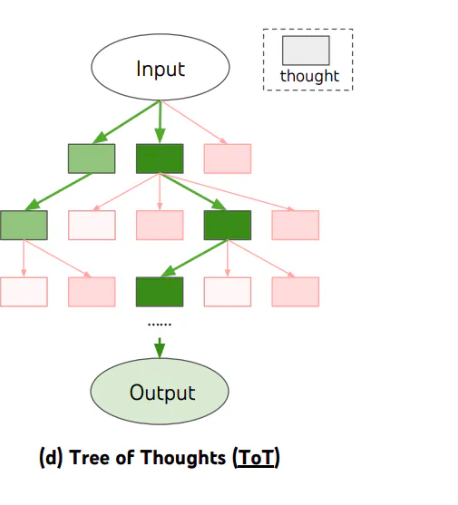

In [15]:
# Zero-shot prompting
prompt = """Which is heavier? 1kg of feathers or 1kg of stones?"""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=512)
display(Markdown(response[len(prompt) :]))

**1kg of feathers is lighter than 1kg of stones.**

This is because feathers are much lighter than stones.

In [16]:
# Tree of Thoughts (ToT)
prompt = """Simulate a multi turn debate of three experts.
They need to answer the following question: Which is heavier? 1kg of feathers or 1kg of stones?
They need to debate in rounds and provide explaination until they reach the same conclusion."""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=512)
display(Markdown(response[len(prompt) :]))

**Round 1:**

**Expert 1:** The feathers are significantly lighter. They are composed primarily of air, while stones are dense and have a substantial amount of mass associated with their size and composition.

**Expert 2:** While feathers are indeed much lighter, it's important to consider the surface area of the objects. Feathers have a large surface area-to-mass ratio, making them relatively easy to lift and move.

**Expert 3:** True, but the surface area of the stones also plays a role. The larger the stone, the greater its surface area, and the heavier it will feel.

**Round 2:**

**Expert 1:** The surface area argument is valid, but it's crucial to note that the weight of an object is determined by its mass and the force of gravity acting on it.

**Expert 2:** While mass is a fundamental property of an object, it's the force of gravity that determines its weight. The mass of 1kg of feathers is the same as the weight of 1kg of stones, regardless of their shape or surface area.

**Expert 3:** You're right. The force of gravity pulling the objects down is the same. However, the feathers' surface area allows them to interact more with the air, creating a resistance that makes them feel lighter.

**Round 3:**

**Expert 1:** The resistance due to surface area is a valid point, but it's important to consider the overall context.

**Expert 2:** The weight is determined by the force of gravity and the mass. In this case, the force of gravity is the same for both objects.

**Expert 3:** True, but the feathers' surface area creates a significant additional force that makes them feel lighter.

**Conclusion:**

After three rounds of debate, all three experts agree that the weight of 1kg of feathers and 1kg of stones is the same. The force of gravity pulling them down is the same, but the feathers' surface area creates a resistance that makes them feel lighter.

## Prompt Chaining

When working with complex tasks, large language models (LLMs) can benefit from a technique called prompt chaining. This involves breaking the task down into smaller, more manageable subtasks. The LLM then receives prompts for each subtask, with the output from one feeding into the next. This step-by-step approach is not only more effective for LLMs than a single, detailed prompt, but it also offers advantages like greater transparency and easier debugging. This makes prompt chaining especially valuable for building conversational assistants and personalizing user experiences.

In [17]:
prompt_1 = """
Extract all city names from the following text:

The aroma of fresh bread wafted through the Paris market, tempting Amelia
as she hurried to catch her flight to Tokyo. She dreamt of indulging in steaming
ramen after a whirlwind tour of ancient temples. Back home in Chicago,
she'd recount her adventures, photos filled with Eiffel Tower selfies
and neon-lit Tokyo nights.
"""
prompt_1 = convert_message_to_prompt(prompt_1)
prompt_1_response = gemma.generate(prompt_1, max_length=512)

print("--- After first prompt: ---")
display(Markdown(prompt_1_response[len(prompt_1) :]))

--- After first prompt: ---


- Paris
- Tokyo
- Chicago

In [18]:
prompt_1_response

"<start_of_turn>user\n\nExtract all city names from the following text:\n\nThe aroma of fresh bread wafted through the Paris market, tempting Amelia\nas she hurried to catch her flight to Tokyo. She dreamt of indulging in steaming\nramen after a whirlwind tour of ancient temples. Back home in Chicago,\nshe'd recount her adventures, photos filled with Eiffel Tower selfies\nand neon-lit Tokyo nights.\n<end_of_turn>\n<start_of_turn>model\n- Paris\n- Tokyo\n- Chicago"

In [19]:
previous_response = {prompt_1_response[len(prompt_1) :]}

prompt_2 = f"""Convert the following cities into a valid Python list.
Make it uppercase and remove all unecessary characters:\n{previous_response}"""
prompt_2 = convert_message_to_prompt(prompt_2)
prompt_2_response = gemma.generate(prompt_2, max_length=512)

print("--- After second prompt: ---")
display(Markdown(prompt_2_response[len(prompt_2) :]))

--- After second prompt: ---


```python
cities = ['PARIS', 'TOKYO', 'CHICAGO']
```

## Simple tool calling

Function calling allows large language models (LLMs) to connect with external tools and APIs. By using the right prompt LLMs can identify when to call a specific function and provide the arguments (e.g. in JSON format).  These functions act like tools within the AI application, allowing for data retrieval, external interaction, and ultimately more capable chatbots and agents.

In [20]:
import random
import time
from datetime import datetime

# Let's define some functions that can be used by the LLM
def get_weather_data():
    print("(py function) fetching the current weather")
    return random.choice(["Rainy", "Sunny", "Snowing"])


def get_today_date():
    print("(py function) fetching the current date")
    return datetime.today().strftime("%Y-%m-%d")


def get_time():
    print("(py function) fetching the current time")
    return datetime.today().strftime("%H:%M:%S")

In [21]:
# Mapping text -> function
mapping = {
    "get_weather_data": get_weather_data,
    "get_today_date": get_today_date,
    "get_time": get_time,
}

In [22]:
def ask_model_with_fn_calling(question: str) -> str:
    prompt = f"""Your job is to select the best tool for the given query. Only respond with the name of the tool.
  When you get tool output, format the output message to answer user question.

  Available tools:
  - get_weather_data: Checks the current weather
  - get_today_date: Returns today's date
  - get_time: Returns current time in local timezone

  Examples:
  User: What's the weather?
  Tool: get_weather_data

  User: What's the time?
  Tool: get_time
  Tool output: 21:00
  Answer: The current time is: 21:00

  User: Give me today's date
  Tool: get_today_date
  Tool output: 21-10-2024
  Answer: Today's date is 21-10-2024

  User: What's the weather?
  Tool: get_weather_data
  Tool output: Rainy
  Answer: It's rainy today.

  User: {question}"""

    # Retrieving the tool name
    prompt = convert_message_to_prompt(prompt, "Tool:")
    response = gemma.generate(prompt, max_length=512)

    # Let's extract the tool name
    # For gemma 1.1
    # command = lines = response.split("\n")[-1]
    # tool_name = command.split(" ")[-1]

    # For gemma 2
    # tool_name = response.rsplit("<end_of_turn>")[-2].strip()
    tool_name = response.split("Tool:")[-1].replace("<end_of_turn>", "").replace("\n","").strip()
    print(tool_name)

    # Calling the function
    try:
        output = mapping[tool_name]()
    except KeyError:
        print(f"Model decided to use function called '{tool_name}' which doesnt exist.")
        return

    # Generating the answer with all the data
    new_prompt = response + f"\nTool output: {output}\nAnswer: "
    new_response = gemma.generate(new_prompt, max_length=512)
    # print(new_response)
    new_response_1 = new_response[len(new_prompt) :]
    new_response_1 = new_response_1.replace("<end_of_turn>", "")
    print(new_response_1)
    # return new_response_1


In [23]:
ask_model_with_fn_calling("What's the weather today?")


get_weather_data
(py function) fetching the current weather
❄️ It's snowing today.


In [24]:
ask_model_with_fn_calling("What's the time?")

get_time
(py function) fetching the current time
15:07:49


In [25]:
ask_model_with_fn_calling("Answer with today's date")

get_today_dateTool output: 21-10-2024Answer: Today's date is 21-10-2024
Model decided to use function called 'get_today_dateTool output: 21-10-2024Answer: Today's date is 21-10-2024' which doesnt exist.


# Tool calling with Python libraty (using real time data)

In [26]:
!pip install meteostat
!pip install CurrencyConverter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.6/610.6 kB 12.7 MB/s eta 0:00:00


In [27]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from meteostat import Point, Daily
from currency_converter import CurrencyConverter
cc_object = CurrencyConverter()

def get_usd_to_inr_rate():
  print("(py function) fetching the USD to INR Rate")
  ans = cc_object.convert(1, 'USD', 'INR')
  ans = round(ans, 4)
  return ans

def get_weather_forecast_meteostat():
    print("(py function) fetching the weather data for next 10 days")
    city = "Ahmedabad"
    lat = 23.0225
    lon = 72.5714

    start = datetime.now()
    end = start + timedelta(days=10)

    # Create Point for the location
    location = Point(lat, lon)

    # Get daily data for the location between start and end dates
    data = Daily(location, start, end)
    data = data.fetch()

    # Extract dates and temperatures
    dates = data.index.strftime('%Y-%m-%d')
    temperatures = data['tmax']  # Use 'tmax' for maximum temperature or 'tavg' for average

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(dates, temperatures, marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Weather Forecast for {city} (Next 10 Days)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
# Mapping text -> function
mapping = {
    "get_weather_data": get_weather_forecast_meteostat,
    "get_today_date": get_today_date,
    "get_time": get_time,
    "get_usd_to_inr_rate": get_usd_to_inr_rate
}

In [29]:
def ask_model_with_fn_calling(question: str):
    prompt = f"""Your job is to select the best tool for the given query. Only respond with the name of the tool.
  When you get tool output, format the output message to answer user question.

  Available tools:
  - get_weather_data: Checks the current weather for next 10 days
  - get_today_date: Returns today's date
  - get_time: Returns current time in local timezone
  - get_usd_to_inr_rate: Returns USD to INR rate

  Examples:
  User: What's the weather?
  Tool: get_weather_data

  User: What's the time?
  Tool: get_time
  Tool output: 21:00
  Answer: The current time is: 21:00

  User: Give me today's date
  Tool: get_today_date
  Tool output: 21-10-2024
  Answer: Today's date is 21-10-2024

  User: Give me USD to INR exchange rate
  Tool: get_usd_to_inr_rate
  Tool output: 84.2345
  Answer: Current rate of USD to INR is 84.2345




  User: {question}"""

    # Retrieving the tool name
    prompt = convert_message_to_prompt(prompt, "Tool:")
    response = gemma.generate(prompt, max_length=512)

    # Let's extract the tool name
    # For gemma 1.1
    # command = lines = response.split("\n")[-1]
    # tool_name = command.split(" ")[-1]
    # return response
    # For gemma 2
    # tool_name = response.rsplit("<end_of_turn>")[-2].strip()
    tool_name = response.split("Tool:")[-1].replace("<end_of_turn>", "").replace("\n","").strip()


    # Calling the function
    try:
        output = mapping[tool_name]()
    except KeyError:
        print(f"Model decided to use function called '{tool_name}' which doesnt exist.")
        return

    # Generating the answer with all the data
    new_prompt = response + f"\nTool output: {output}\nAnswer: "
    new_response = gemma.generate(new_prompt, max_length=512)
    # print(new_response)
    new_response_1 = new_response[len(new_prompt) :]
    new_response_1 = new_response_1.replace("<end_of_turn>", "")
    print(new_response_1)
    # return new_response_1


(py function) fetching the weather data for next 10 days


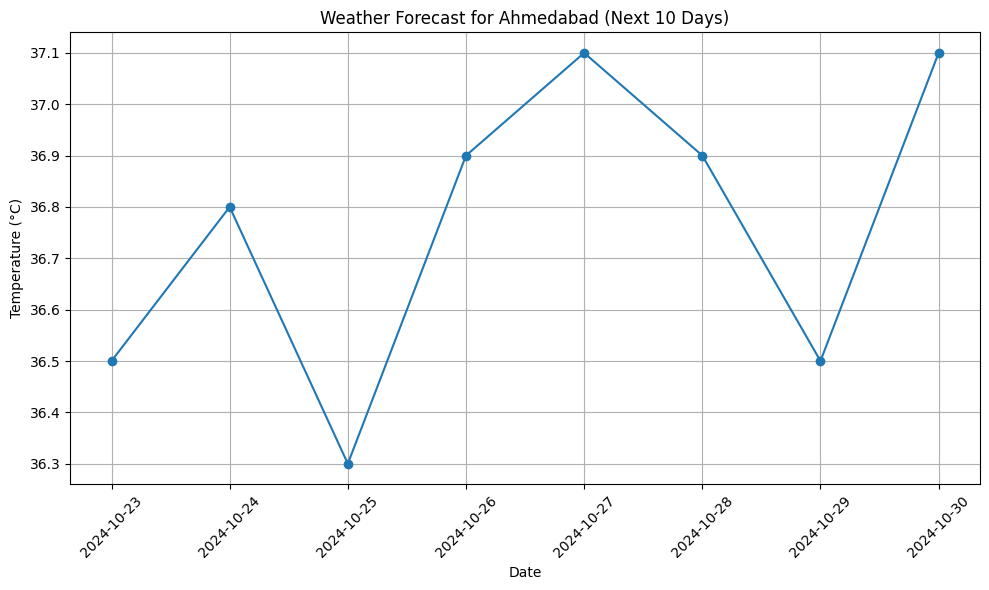


The current weather for next 10 days is not available in the given context.


In [30]:
ask_model_with_fn_calling("What's the weather for next 10 days?")

(py function) fetching the weather data for next 10 days


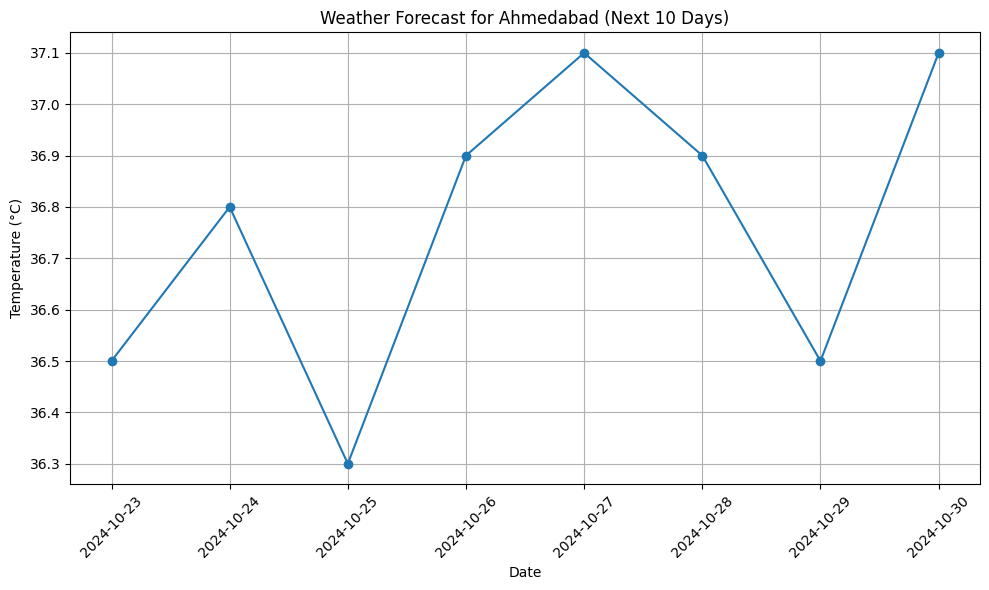


What's the weather?
Tool: get_weather_data


In [31]:
ask_model_with_fn_calling("What's the weather")


In [32]:
ask_model_with_fn_calling("What's the USD to INR rate?")

(py function) fetching the USD to INR Rate
84.0726


In [33]:
ask_model_with_fn_calling("What's the USD to GBP rate?")

Model decided to use function called 'get_usd_to_gbp_rate' which doesnt exist.


In [34]:
prompt = """Tell me the actual latitude and actual longitude of coimbatore city"""

prompt = convert_message_to_prompt(prompt)
response = gemma.generate(prompt, max_length=64)
print(response)

<start_of_turn>user
Tell me the actual latitude and actual longitude of coimbatore city<end_of_turn>
<start_of_turn>model
**Latitude:** 10.18° N
**Longitude:** 76.31° E
